# Estival/Nevergrad

Estival wraps summer2 models along with associated data and parameter information, for use in a variety of calibration and optimization contexts

In [1]:
import summer2
import numpy as np
import pandas as pd

In [2]:
from summer2.extras import test_models

In [3]:
m = test_models.sir()
defp = m.get_default_parameters()
defp

{'contact_rate': 0.4, 'recovery_rate': 0.1}

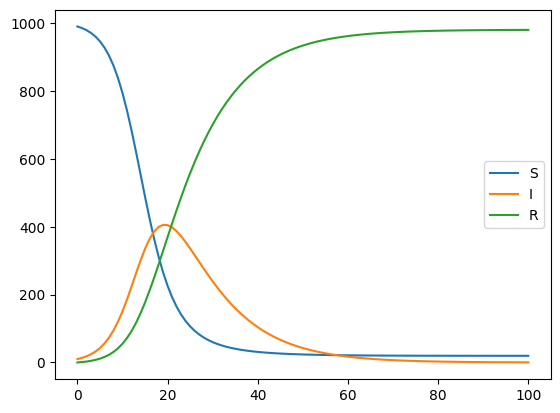

In [4]:
m.run()
m.get_outputs_df().plot();

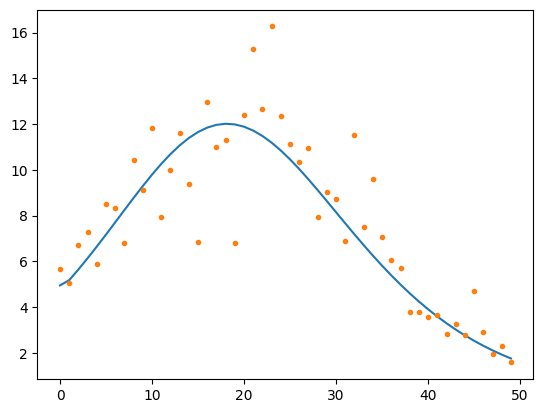

In [5]:
# Now let's construct some noisy data to fit to

target_params = {"contact_rate": 0.5, "recovery_rate": 0.4}

m.run(target_params)
do_def = m.get_derived_outputs_df()
obs_clean = do_def["incidence"].iloc[0:50]
obs_noisy = obs_clean * np.exp(np.random.normal(0.0,0.2,len(obs_clean)))
obs_clean.plot()
obs_noisy.plot(style='.');

In [6]:
# The following imports are the 'building blocks' of estival models

# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Nevergrad

In this example, we will be using nevergrad - a gradient free optimization toolkit

https://facebookresearch.github.io/nevergrad/

Estival provides simple wrappers to use BayesianCompartmentalModel objects with a number of optimizers



In [7]:
# Import nevergrad
import nevergrad as ng

# Import our convenience wrapper
from estival.optimization.nevergrad import optimize_model

In [8]:
# Specify a Truncated normal target with a free dispersion parameter,
# using the noisy data we constructed earlier
targets = [
    est.TruncatedNormalTarget("incidence", obs_noisy, (0.0,np.inf),
        esp.UniformPrior("incidence_dispersion",(0.1, obs_noisy.max()*0.1)))
]

In [9]:
# Priors over our 2 model parameters
priors = [
    esp.UniformPrior("contact_rate", (0.01,1.0)),
    esp.TruncNormalPrior("recovery_rate", 0.5, 0.2, (0.01,1.0)),
]

In [10]:
# The BayesianCompartmentalModel class is the primary entry point to all optimization and calibration
# methods in estival
# It takes a CompartmentalModel object, default parameters, priors, and targets
# The default parameters will be used as fixed values when no prior is specified for a given parameter

bcm = BayesianCompartmentalModel(m, m.get_default_parameters(), priors, targets)

In [11]:
# The resulting object contains all priors, including dispersion parameters, nested values etc
bcm.priors

{'contact_rate': <class 'estival.priors.UniformPrior'> contact_rate,
 'recovery_rate': <class 'estival.priors.TruncNormalPrior'> recovery_rate,
 'incidence_dispersion': <class 'estival.priors.UniformPrior'> incidence_dispersion}

In [12]:
# ... and a loglikelihood evaluation function
# This function requires values for all the bcm.priors - not just the CompartmentalModel parameters

ok_params = {"contact_rate": 0.3, "recovery_rate": 0.2, "incidence_dispersion": 1.0}

print(bcm.loglikelihood(**ok_params))

bad_params = {"contact_rate": 0.9, "recovery_rate": 0.6, "incidence_dispersion": 1.0}

print(bcm.loglikelihood(**bad_params))

-11.726571088073127
-103.55002293162534


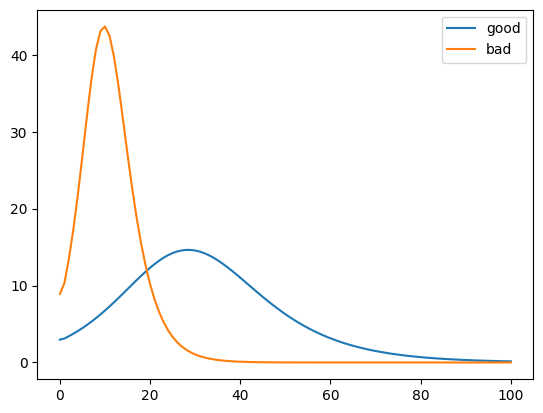

In [13]:
# It also provides a convenience method for running parameters against the specified model

ax = bcm.run(ok_params).derived_outputs["incidence"].plot(label="good")
bcm.run(bad_params).derived_outputs["incidence"].plot(label="bad")
ax.legend();

# Using the optimizers

optimize_model is the main entry point to using nevergrad optimizers.<br>
It wraps the loglikelihood function for minimization (0.0 - loglikelihood) of the model<br>

See the nevergrad documentation regarding different optimizers<br>
https://facebookresearch.github.io/nevergrad/optimization.html#choosing-an-optimizer

In [14]:
# TwoPointsDE is a good suggested default for some of our typical use cases
opt_class = ng.optimizers.TwoPointsDE
orunner = optimize_model(bcm, opt_class=opt_class)

In [15]:
# You can also suggest starting points for the optimization (as well as specify an init method for unsuggested points)
# This is the "midpoint" method by default (ie the 0.5 ppf of the prior distribution)
orunner = optimize_model(bcm, opt_class=opt_class, suggested=defp, init_method="midpoint")

In [16]:
# Some optimizers have their own initiliazation routines which will override the settings to optimize_model
# For example, the following optimizer performs a LHS search to select its initial points
# opt_class = ng.families.DifferentialEvolution(initialization="LHS", crossover="twopoints")

In [17]:
# Here we run the optimizer in a loop, inspecting the current best point at each iteration
# Using the loss information at each step can provide the basis for stopping conditions

for i in range(8):
    # Run the minimizer for a specified 'budget' (ie number of evaluations)
    rec = orunner.minimize(100)
    # Print the loss (objective function value) of the current recommended parameters
    print(rec.loss)

2.1476426336042596
2.0256786062175434
2.0256786062175434
2.0256786062175434
1.9985978395218644
1.9953542554669026
1.9713827398971255
1.9713827398971255


In [18]:
mle_params = rec.value[1]
mle_params

{'contact_rate': 0.4661381044889661,
 'recovery_rate': 0.3681956652253679,
 'incidence_dispersion': 1.6005761925669986}

In [19]:
# Run the model against the parameter estimates
res = bcm.run(mle_params)

<Axes: >

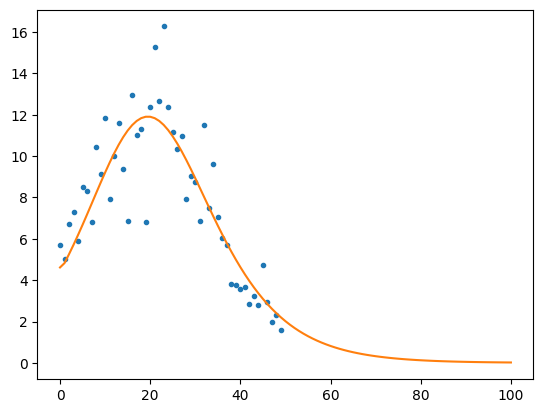

In [20]:
target = "incidence"

# You can access the targets from the BCM
bcm.targets[target].data.plot(style='.')
res.derived_outputs[target].plot()

-0.0829909915845509


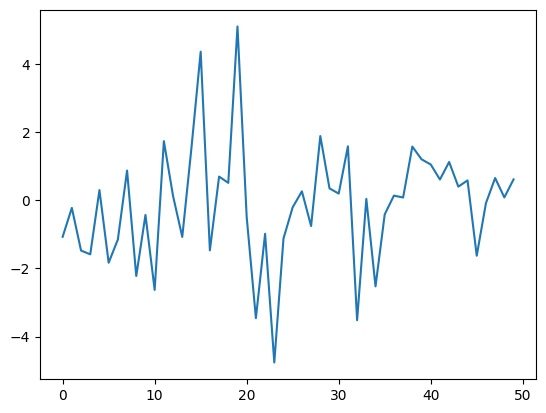

In [21]:
# Inspect the bias of the resulting output

diff = (res.derived_outputs[target] - bcm.targets[target].data)
print(diff.mean() / diff.std())
diff.plot();

# That's it!

Try experimenting with different optimizers, and running with your own models,
or use the MLE outputs as a starting point for further optimizations